# `get_data()` Demo Notebook from `CIROH-UVM/forecast-workflow`

## Setup
1. Clone the [forecast-workflow repository](https://github.com/CIROH-UVM/forecast-workflow/tree/main) to your user space on the testbed
2. Launch Jupyter Lab and select the kernel called "forecast"
3. Add the path to your cloned repo to you Python path by running the cell below (only run once per notebook)

In [1]:
# import sys
# sys.path.append('/your/path/to/forecast-workflow')

## NWM forecasted streamflow data


In [2]:
"""
A function to download and process NWM hydrology forecast data to return nested dictionary of pandas series fore each variable, for each location.

Args:
-- forecast_datetime (str, date, or datetime) [req]: the start date and time (00, 06, 12, 18) of the forecast to download. Times are assumed to be UTC time.
-- end_datetime (str, date, or datetime) [req]: the end date and time for the forecast. GFS forecasts 16-days out for a given start date.
-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to download forecast data for.
-- forecast_type (str) [req]: The type of forecast.
-- data_dir (str) [opt]: directory to store donwloaded data. Defaults to OS's default temp directory.
-- dwnld_threads (int) [opt]: number of threads to use for downloads. Default is half of OS's available threads.
-- load_threads (int) [opt]: number of threads to use for reading data. Default is 2 for GFS, since file reads are already pretty fast.
-- forecast_cycle (str) [req]: The starting time for the forecasts. valid values are 00, 06, 12, 18
-- google_buckets (bool) [opt]: Flag determining wether or not to use google buckets for nwm download as opposed to NOMADs site.
-- archive (bool) [opt]: Flag determining wether or not data you are grabbing is older than the last two days (relevant for NWM only)
-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:
								{locationID1:{
									var1_name:pd.Series,
									var2_name:pd.Series,
									...},
								locationID2:{...},
								...
								}
								Alternative return type is "dataframe", which smashes all data into a single dataframe muliIndex'd by station ID, then timestamp	
Returns:
NWM data in the format specified by return_type
"""

'\nA function to download and process NWM hydrology forecast data to return nested dictionary of pandas series fore each variable, for each location.\n\nArgs:\n-- forecast_datetime (str, date, or datetime) [req]: the start date and time (00, 06, 12, 18) of the forecast to download. Times are assumed to be UTC time.\n-- end_datetime (str, date, or datetime) [req]: the end date and time for the forecast. GFS forecasts 16-days out for a given start date.\n-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to download forecast data for.\n-- forecast_type (str) [req]: The type of forecast.\n-- data_dir (str) [opt]: directory to store donwloaded data. Defaults to OS\'s default temp directory.\n-- dwnld_threads (int) [opt]: number of threads to use for downloads. Default is half of OS\'s available threads.\n-- load_threads (int) [opt]: number of threads to use for reading data. Default is 2 for GFS, since file reads are already pretty fast.\n-- forecas

In [3]:
import data.nwm_fc as nwm
import datetime as dt
import pandas as pd

fc_start_dt = dt.datetime(2024, 1, 16, 6)
# without an hour specified, will default to midnight forecast cycle
# fc_start_dt = "202401016"

# use the same hour as our start datetime, so that we get a full 10 days of fc data
fc_end_dt = dt.datetime(2024, 1, 26, 6)

# define some locations to grab data for. Reach IDs for the NWM can be found at: 
# https://water.noaa.gov/map
reaches =  {"Missisquoi River":"166176984",
			"Jewett Brook":"4587092",
            "Mill River":"4587100"}

fc_type = "medium_range_mem1"

# define a directory in which to download NWM data
# this specifc directroy hosts a large swath of NWM and GFS data used collectively by CIROH researchers
data_directory = "/netfiles/ciroh/7dayHABsHindcast/hindcastData"

# yes, we want to use google buckets for all data older than yesterday
buckets = True
arch = True


In [7]:
nwm_data = nwm.get_data(forecast_datetime = fc_start_dt,
			 		   end_datetime = fc_end_dt,
			 		   locations = reaches,
					   forecast_type = fc_type,
					   data_dir = data_directory,
					   google_buckets = buckets,
					   archive = arch)

TASK INITIATED: Download 237-hour NWM hydrology forecasts for the following date: 20240116
Skipping download; nwm.t06z.medium_range.channel_rt_1.f003.conus.nc found at: /netfiles/ciroh/7dayHABsHindcast/hindcastData/nwm/2024/nwm.20240116/medium_range_mem1/nwm.t06z.medium_range.channel_rt_1.f003.conus.nc
Skipping download; nwm.t06z.medium_range.channel_rt_1.f006.conus.nc found at: /netfiles/ciroh/7dayHABsHindcast/hindcastData/nwm/2024/nwm.20240116/medium_range_mem1/nwm.t06z.medium_range.channel_rt_1.f006.conus.nc
Skipping download; nwm.t06z.medium_range.channel_rt_1.f009.conus.nc found at: /netfiles/ciroh/7dayHABsHindcast/hindcastData/nwm/2024/nwm.20240116/medium_range_mem1/nwm.t06z.medium_range.channel_rt_1.f009.conus.nc
Skipping download; nwm.t06z.medium_range.channel_rt_1.f012.conus.nc found at: /netfiles/ciroh/7dayHABsHindcast/hindcastData/nwm/2024/nwm.20240116/medium_range_mem1/nwm.t06z.medium_range.channel_rt_1.f012.conus.nc
Skipping download; nwm.t06z.medium_range.channel_rt_1.f01

In [8]:
nwm_data

{'Missisquoi River': {'streamflow': time
  2024-01-16 09:00:00+00:00    62.669999
  2024-01-16 12:00:00+00:00    63.149999
  2024-01-16 15:00:00+00:00    62.909999
  2024-01-16 18:00:00+00:00    62.119999
  2024-01-16 21:00:00+00:00    61.089999
                                 ...    
  2024-01-25 15:00:00+00:00    23.609999
  2024-01-25 18:00:00+00:00    23.489999
  2024-01-25 21:00:00+00:00    23.399999
  2024-01-26 00:00:00+00:00    23.989999
  2024-01-26 03:00:00+00:00    24.399999
  Name: streamflow, Length: 79, dtype: float64},
 'Jewett Brook': {'streamflow': time
  2024-01-16 09:00:00+00:00    0.20
  2024-01-16 12:00:00+00:00    0.40
  2024-01-16 15:00:00+00:00    0.65
  2024-01-16 18:00:00+00:00    0.78
  2024-01-16 21:00:00+00:00    0.82
                               ... 
  2024-01-25 15:00:00+00:00    0.32
  2024-01-25 18:00:00+00:00    0.31
  2024-01-25 21:00:00+00:00    0.31
  2024-01-26 00:00:00+00:00    0.31
  2024-01-26 03:00:00+00:00    0.31
  Name: streamflow, Length

In [6]:
pd.DataFrame(nwm_data['Missisquoi River']['streamflow'])

,streamflow
time,
2024-01-16 09:00:00+00:00,62.669999
2024-01-16 12:00:00+00:00,63.149999
2024-01-16 15:00:00+00:00,62.909999
2024-01-16 18:00:00+00:00,62.119999
2024-01-16 21:00:00+00:00,61.089999
...,...
2024-01-25 15:00:00+00:00,23.609999
2024-01-25 18:00:00+00:00,23.489999
2024-01-25 21:00:00+00:00,23.399999


## USGS observed streamflow data

In [7]:
"""
A function to download and process USGS observational hydrology data to return nested dictionary of pandas series fore each variable, for each location.

Args:
-- start_date (str, date, or datetime) [req]: the start date for which to grab USGS data
-- end_date (str, date, or datetime) [req]: the end date for which to grab USGS data
-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to get USGS data for.
-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:
							{locationID1:{
								var1_name:pd.Series,
								var2_name:pd.Series,
								...},
							locationID2:{...},
							...
							}
							Alternative return type is "dataframe", which smashes all data into a single dataframe muliIndex'd by station ID, then timestamp

Returns:
USGS observed streamflow data for the given stations in the format specified by return_type
"""

'\nA function to download and process USGS observational hydrology data to return nested dictionary of pandas series fore each variable, for each location.\n\nArgs:\n-- start_date (str, date, or datetime) [req]: the start date for which to grab USGS data\n-- end_date (str, date, or datetime) [req]: the end date for which to grab USGS data\n-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to get USGS data for.\n-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:\n\t\t\t\t\t\t\t{locationID1:{\n\t\t\t\t\t\t\t\tvar1_name:pd.Series,\n\t\t\t\t\t\t\t\tvar2_name:pd.Series,\n\t\t\t\t\t\t\t\t...},\n\t\t\t\t\t\t\tlocationID2:{...},\n\t\t\t\t\t\t\t...\n\t\t\t\t\t\t\t}\n\t\t\t\t\t\t\tAlternative return type is "dataframe", which smashes all data into a single dataframe muliIndex\'d by station ID, then timestamp\n\nReturns:\nUSGS observed streamflow data for the 

In [8]:
import data.usgs_ob as usgs
import matplotlib.pyplot as plt

In [9]:
# USGS site numbers can be found at:
# https://maps.waterdata.usgs.gov/mapper/index.html
usgs_stations = {"Missisquoi River":"04294000",
				 "Jewett Brook":"04292810",
            	 "Mill River":"04292750"}

In [10]:
usgs_data = usgs.get_data(start_date = "20240116",
						  end_date = "20240126",
						  locations = usgs_stations)

In [11]:
df = pd.DataFrame(usgs_data['Missisquoi River']['streamflow'].astype('float') * 0.0283168)
# pd.options.display.max_rows = 60
df

,streamflow
time,
2024-01-16 00:00:00+00:00,66.261312
2024-01-16 00:15:00+00:00,66.261312
2024-01-16 00:30:00+00:00,65.411808
2024-01-16 00:45:00+00:00,66.261312
2024-01-16 01:00:00+00:00,65.411808
...,...
2024-01-26 22:45:00+00:00,58.898944
2024-01-26 23:00:00+00:00,59.748448
2024-01-26 23:15:00+00:00,60.314784


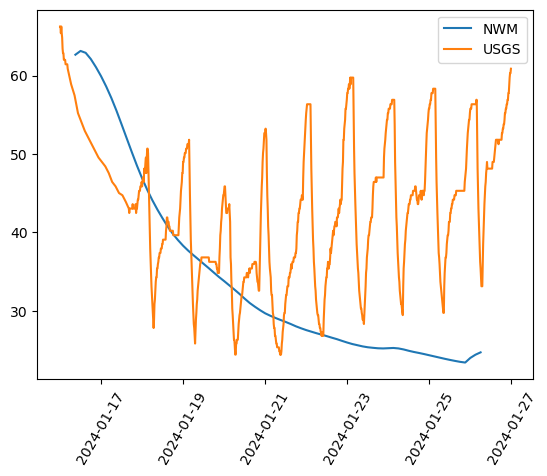

In [12]:
plt.plot(nwm_data['Missisquoi River']['streamflow'], label='NWM')
# Convert from cubic ft/s (USGS) to cubic m/s (NWM)
plt.plot(usgs_data['Missisquoi River']['streamflow'].astype('float') * 0.0283168, label='USGS')
plt.xticks(rotation = 60)
plt.legend()

plt.show()

## GFS forecasted meterological data

In [13]:
"""
Download specified GFS forecast data and return nested dictionary of pandas series fore each variable, for each location.

Args:
-- forecast_datetime (str, date, or datetime) [req]: the start date and time (00, 06, 12, 18) of the forecast to download. Times are assumed to be UTC time.
-- end_datetime (str, date, or datetime) [req]: the end date and time for the forecast. GFS forecasts 16-days out for a given start date.
-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to download forecast data for.
-- data_dir (str) [opt]: directory to store donwloaded data. Defaults to OS's default temp directory.
-- dwnld_threads (int) [opt]: number of threads to use for downloads. Default is half of OS's available threads.
-- load_threads (int) [opt]: number of threads to use for reading data. Default is 2 for GFS, since file reads are already pretty fast.
-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:
								{locationID1:{
									var1_name:pd.Series,
									var2_name:pd.Series,
									...},
								locationID2:{...},
								...
								}
								Alternative return type is "dataframe", which smashes all data into a single dataframe muliIndex'd by station ID, then timestamp

Returns:
GFS forecast data for the given locations in the format specified by return_type
"""

'\nDownload specified GFS forecast data and return nested dictionary of pandas series fore each variable, for each location.\n\nArgs:\n-- forecast_datetime (str, date, or datetime) [req]: the start date and time (00, 06, 12, 18) of the forecast to download. Times are assumed to be UTC time.\n-- end_datetime (str, date, or datetime) [req]: the end date and time for the forecast. GFS forecasts 16-days out for a given start date.\n-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to download forecast data for.\n-- data_dir (str) [opt]: directory to store donwloaded data. Defaults to OS\'s default temp directory.\n-- dwnld_threads (int) [opt]: number of threads to use for downloads. Default is half of OS\'s available threads.\n-- load_threads (int) [opt]: number of threads to use for reading data. Default is 2 for GFS, since file reads are already pretty fast.\n-- return_type (string) [opt]: string indicating which format to return data in. Default

In [29]:
import data.gfs_fc as gfs

start_dt = dt.datetime(2024, 2, 1)
# wothout an hour specified, will default to midnight forecast cycle
# fc_start_dt = "202401016"

# use the same hour as our start datetime, so that we get a full 10 days of fc data
end_dt = dt.datetime(2024, 2, 2)

# define some locations to grab data for. Dictionary value must be lat/long tuple, up to 0.25 resolution
stations = {'401': (45.00, -73.25),
			'402': (44.75, -73.25),
			'403': (44.75, -73.25)}

# define a directory in which to download NWM data
data_directory = "/data/users/n/b/nbeckage/forecastData/"

In [30]:
gfs_data = gfs.get_data(forecast_datetime = start_dt,
						end_datetime = end_dt,
						locations = stations,
						data_dir = data_directory)

In [32]:
# let's check out the meterological variables downloaded - hardcoded for now
gfs_data['401'].keys()

dict_keys(['TCDC', 'U10', 'V10', 'T2', 'RH2', 'RAIN', 'CPOFP', 'SWDOWN'])

In [17]:
gfs_data['401']['T2']

time
2024-02-01 00:00:00+00:00    273.619598
2024-02-01 01:00:00+00:00    273.607239
2024-02-01 02:00:00+00:00    273.689972
2024-02-01 03:00:00+00:00    273.662231
2024-02-01 04:00:00+00:00    273.768982
2024-02-01 05:00:00+00:00    273.668457
2024-02-01 06:00:00+00:00    273.806213
2024-02-01 07:00:00+00:00    273.848785
2024-02-01 08:00:00+00:00    273.742584
2024-02-01 09:00:00+00:00    273.820190
2024-02-01 10:00:00+00:00    273.937866
2024-02-01 11:00:00+00:00    274.017181
2024-02-01 12:00:00+00:00    274.092316
2024-02-01 13:00:00+00:00    274.176514
2024-02-01 14:00:00+00:00    274.258453
2024-02-01 15:00:00+00:00    274.342010
2024-02-01 16:00:00+00:00    274.521729
2024-02-01 17:00:00+00:00    274.560364
2024-02-01 18:00:00+00:00    274.607452
2024-02-01 19:00:00+00:00    274.666534
2024-02-01 20:00:00+00:00    274.444336
2024-02-01 21:00:00+00:00    274.494080
2024-02-01 22:00:00+00:00    274.595276
2024-02-01 23:00:00+00:00    274.711517
2024-02-02 00:00:00+00:00    274.59

## Observed local climatological data from NOAA
[NCEI Data Service API User Documentation](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation)

Additional LCD station IDs can be found at: https://www.ncei.noaa.gov/cdo-web/datatools/lcd

In [18]:
"""
A function to download and process NOAA Local Climatological Data data to return nested dictionary of pandas series for each variable, for each location.

Args:
-- start_date (str, date, or datetime) [req]: the start date for which to grab LCD data
-- end_date (str, date, or datetime) [req]: the end date for which to grab LCD data
-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to get USGS data for.
-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:
								{locationID1:{
									var1_name:pd.Series,
									var2_name:pd.Series,
									...},
								locationID2:{...},
								...
								}
								Alternative return type is "dataframe", which smashes all data into a single dataframe muliIndex'd by station ID, then timestamp

Returns:
NOAA Local Climatological Data (total cloud cover and precipitation currently) for the dat range and locations provided
"""

'\nA function to download and process NOAA Local Climatological Data data to return nested dictionary of pandas series for each variable, for each location.\n\nArgs:\n-- start_date (str, date, or datetime) [req]: the start date for which to grab LCD data\n-- end_date (str, date, or datetime) [req]: the end date for which to grab LCD data\n-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to get USGS data for.\n-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:\n\t\t\t\t\t\t\t\t{locationID1:{\n\t\t\t\t\t\t\t\t\tvar1_name:pd.Series,\n\t\t\t\t\t\t\t\t\tvar2_name:pd.Series,\n\t\t\t\t\t\t\t\t\t...},\n\t\t\t\t\t\t\t\tlocationID2:{...},\n\t\t\t\t\t\t\t\t...\n\t\t\t\t\t\t\t\t}\n\t\t\t\t\t\t\t\tAlternative return type is "dataframe", which smashes all data into a single dataframe muliIndex\'d by station ID, then timestamp\n\nReturns:\nNOAA Local Climatologic

In [19]:
import data.lcd_ob as lcd

In [34]:
lcd_data = lcd.get_data(start_date = start_dt,
						end_date = end_dt,
						locations = {"BTV":"72617014742"})

In [35]:
# Local Climatological Dataset (LCD) only provides total cloud cover (%) and rain data
lcd_data['BTV'].keys()

dict_keys(['TCDC', 'RAIN'])

In [36]:
lcd_data['BTV']['TCDC']

time
2024-02-01 00:54:00+00:00    1.0
2024-02-01 01:54:00+00:00    1.0
2024-02-01 02:54:00+00:00    1.0
2024-02-01 03:54:00+00:00    1.0
2024-02-01 04:54:00+00:00    1.0
                            ... 
2024-02-02 21:54:00+00:00    1.0
2024-02-02 22:31:00+00:00    1.0
2024-02-02 22:54:00+00:00    1.0
2024-02-02 23:54:00+00:00    1.0
2024-02-02 23:59:00+00:00    1.0
Name: TCDC, Length: 82, dtype: float64

## Observed meterology data from UVM Forest Ecosystem Monitoring Cooperative (FEMC)
Right now can be used to get Colchester reef quality-controlled met data

In [23]:
"""
A function to download and process observational meterological data from UVM FEMC (Forest Ecosysytem Monitoring Cooperative - https://www.uvm.edu/femc/) to return nested dictionary of pandas series for each variable, for each location.

Args:
-- start_date (str, date, or datetime) [req]: the start date for which to grab FEMC data
-- end_date (str, date, or datetime) [req]: the end date for which to grab FEMC data
-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to get FEMC data for.
-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:
								{locationID1:{
									var1_name:pd.Series,
									var2_name:pd.Series,
									...},
								locationID2:{...},
								...
								}
								Alternative return type is "dataframe", which smashes all data into a single dataframe muliIndex'd by station ID, then timestamp

Returns:
FEMC obsrvational meterological data for the specifed data range and locations, in the format specified by return_type
"""

'\nA function to download and process observational meterological data from UVM FEMC (Forest Ecosysytem Monitoring Cooperative - https://www.uvm.edu/femc/) to return nested dictionary of pandas series for each variable, for each location.\n\nArgs:\n-- start_date (str, date, or datetime) [req]: the start date for which to grab FEMC data\n-- end_date (str, date, or datetime) [req]: the end date for which to grab FEMC data\n-- locations (dict) [req]: a dictionary (stationID/name:IDValue/latlong tuple) of locations to get FEMC data for.\n-- return_type (string) [opt]: string indicating which format to return data in. Default is "dict", which will return data in a nested dict format:\n\t\t\t\t\t\t\t\t{locationID1:{\n\t\t\t\t\t\t\t\t\tvar1_name:pd.Series,\n\t\t\t\t\t\t\t\t\tvar2_name:pd.Series,\n\t\t\t\t\t\t\t\t\t...},\n\t\t\t\t\t\t\t\tlocationID2:{...},\n\t\t\t\t\t\t\t\t...\n\t\t\t\t\t\t\t\t}\n\t\t\t\t\t\t\t\tAlternative return type is "dataframe", which smashes all data into a single dataf

In [24]:
import data.femc_ob as femc

In [25]:
femc_data = femc.get_data(start_date = start_dt,
						  end_date = end_dt)

In [26]:
# taking a look at what meterological vars we have
femc_data['CR'].keys()

dict_keys(['T2', 'SWDOWN', 'RH2', 'WSPEED', 'WDIR'])

In [27]:
femc_data['CR']['T2']

time
2024-02-01 00:00:00+00:00    1.900
2024-02-01 00:15:00+00:00    1.853
2024-02-01 00:30:00+00:00    1.813
2024-02-01 00:45:00+00:00    1.743
2024-02-01 01:00:00+00:00    1.635
                             ...  
2024-02-02 22:45:00+00:00   -2.053
2024-02-02 23:00:00+00:00   -2.146
2024-02-02 23:15:00+00:00   -2.237
2024-02-02 23:30:00+00:00   -2.217
2024-02-02 23:45:00+00:00   -2.292
Name: T2, Length: 192, dtype: float64